# **SIC5: Air Quality Classification `Group 6`**

**Objective**: Developing a machine learning model to predict air quality classification based on 2 sensor data inputs.

# **Import Libraries**

In [38]:
import pickle
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# **Get the Data**

The dataset to be used is [**Air Quality Dataset for ADL Classification**](https://www.kaggle.com/datasets/saurabhshahane/adl-classification/data), which is indoor air quality data from 6 low-cost sensors generated from 4 types of daily activities (Activities of Daily Living / ADL). The six sensors used are MQ-2, MQ-9, MQ-135, MQ-137, MQ138, and MG-811. Meanwhile, the 4 types of daily activities recorded are as follows.
  1. **Normal situation - Activity**: clean air, a person sleeping or studying or resting.
  2. **Preparing meals - Activities**: cooking meat or pasta, fried vegetables. One or two people in the room, forced air circulation.
  3. **Presence of smoke - Activity**: burning paper and wood for a short period of time in a room with closed windows and doors.
  4. **Cleaning - Activity**: use of spray and liquid detergents with ammonia and / or alcohol. Forced air circulation can be activated or deactivated.

These four types of daily activities produce gases that are recorded through the six sensors. The four types of activities also produce different levels of gases, which when mapped into the context of air quality, will be as follows.
1. **Sehat** (good);
2. **Sedang** (moderate);
3. **Tidak Sehat** (unhealthy);
4. **Sangat Tidak Sehat** (very unhealthy).

In this way, we can develop a machine learning model that can classify air quality based on this dataset.

In [39]:
# Load CSV file
df = pd.read_csv('datasets/dataset.csv')
df.columns = ['mq2', 'mq9', 'mq135', 'mq137', 'mq138', 'mg811', 'category']
df.head()

,mq2,mq9,mq135,mq137,mq138,mg811,category
0,641,674,1156,1652,1410,2433,4
1,642,646,1159,1643,1455,2361,4
2,640,590,1105,1608,1459,2427,4
3,616,627,1192,1637,1466,2447,4
4,780,896,1438,1813,1489,2434,4


In [40]:
# df = df.astype({
#     'mq2': 'int64',
#     'mq9': 'int64',
#     'mq135': 'int64',
#     'mq137': 'int64',
#     'mq138': 'int64',
#     'mg811': 'int64',
#     'category': 'category'
# })

# **Explore the Data**

## **Data Details**

In [41]:
# View examples of dataset contents
df.sample(5)

,mq2,mq9,mq135,mq137,mq138,mg811,category
739,506,573,993,1547,1644,2428,4
1156,653,642,1327,1639,1445,2142,4
862,438,665,910,1572,1202,2291,1
1779,344,475,988,1487,913,2256,1
1473,573,669,1173,1677,1456,2316,4


In [42]:
# Detailed variable information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   mq2       1844 non-null   int64
 1   mq9       1844 non-null   int64
 2   mq135     1844 non-null   int64
 3   mq137     1844 non-null   int64
 4   mq138     1844 non-null   int64
 5   mg811     1844 non-null   int64
 6   category  1844 non-null   int64
dtypes: int64(7)
memory usage: 101.0 KB


In [43]:
# Check and count rows with NaN values
na_count = df.isna().sum().sum()
print(f'Total rows with NaN values: {na_count}')

Total rows with NaN values: 0


In [44]:
feature_columns = ['mq2', 'mq9', 'mq135', 'mq137', 'mq138', 'mg811']
target_column = 'category'

In [45]:
# View unique values ​​in target variables
print(f"Unique value of variable Type: {df[target_column].unique()}")

Unique value of variable Type: [4 3 1 2]


Based on examples of data content and detailed variable information, some information is obtained.

- The dataset contains 7 variables
  - 6 feature variables
  - 1 Target variables
- There are no `null` values ​​in the dataset
- Feature and target variables have the data type number
  - The target variable is of type integer even though it actually indicates a category. `[4 3 1 2]`

Data preparation steps.
- Because in this task the sensors that we can use are MQ-2 (`mq2`) and MQ-135 (`mq135`), the other four sensor data will be deleted.

## **Explanatory Data Analysis**

In [46]:
df.describe().round(2)

,mq2,mq9,mq135,mq137,mq138,mg811,category
count,1844.00,1844.00,1844.00,1844.00,1844.00,1844.00,1844.00
mean,587.41,653.44,1165.99,1609.22,1302.11,2246.20,2.37
std,190.50,173.40,208.84,118.82,279.53,181.00,1.21
min,263.00,346.00,753.00,1323.00,773.00,1797.00,1.00
25%,429.75,517.00,994.75,1508.00,1086.00,2136.75,1.00
50%,550.50,622.00,1162.00,1610.00,1264.00,2265.00,2.00
75%,713.00,746.00,1309.00,1692.25,1553.25,2372.00,4.00
max,1266.00,1388.00,1738.00,1926.00,1948.00,2703.00,4.00


array([[<Axes: title={'center': 'mq2'}>, <Axes: title={'center': 'mq9'}>,
        <Axes: title={'center': 'mq135'}>],
       [<Axes: title={'center': 'mq137'}>,
        <Axes: title={'center': 'mq138'}>,
        <Axes: title={'center': 'mg811'}>],
       [<Axes: title={'center': 'category'}>, <Axes: >, <Axes: >]],
      dtype=object)

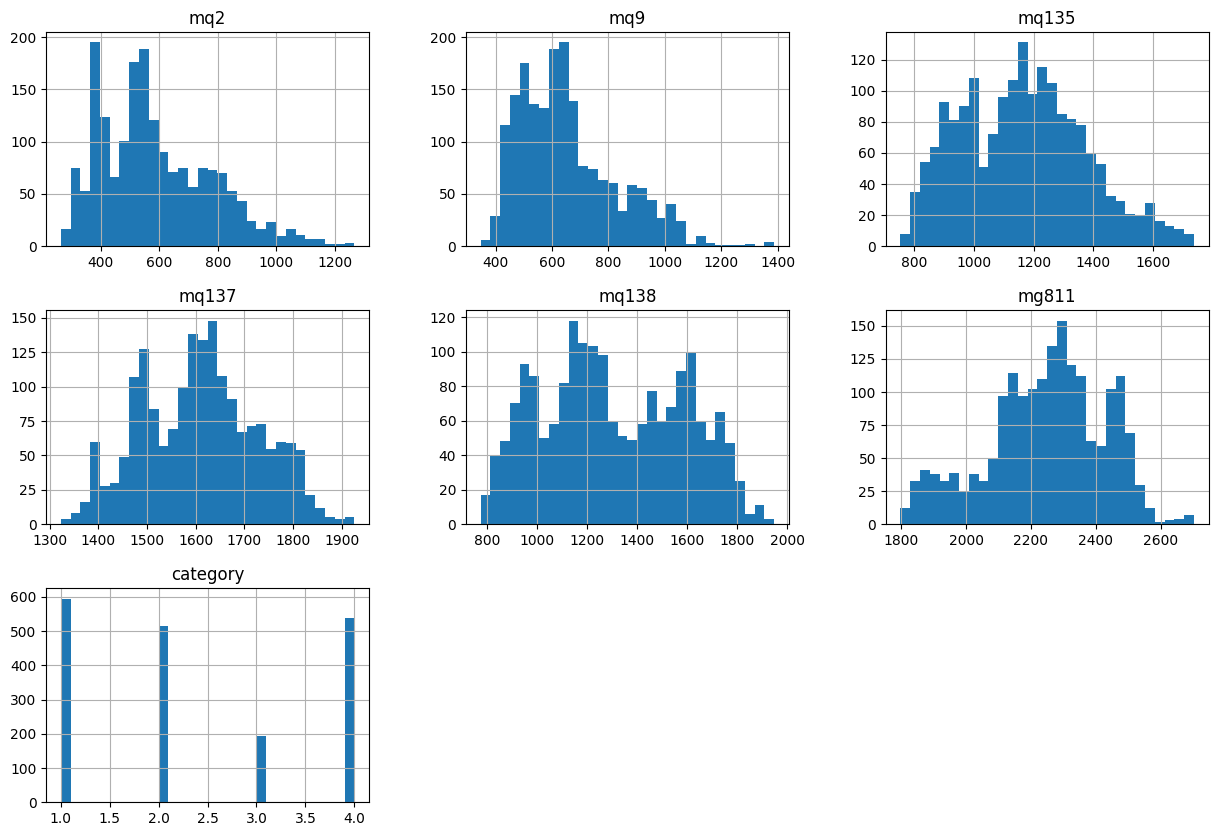

In [47]:
# View the histogram of the numeric variables
df.hist(bins=30, figsize=(15, 10))

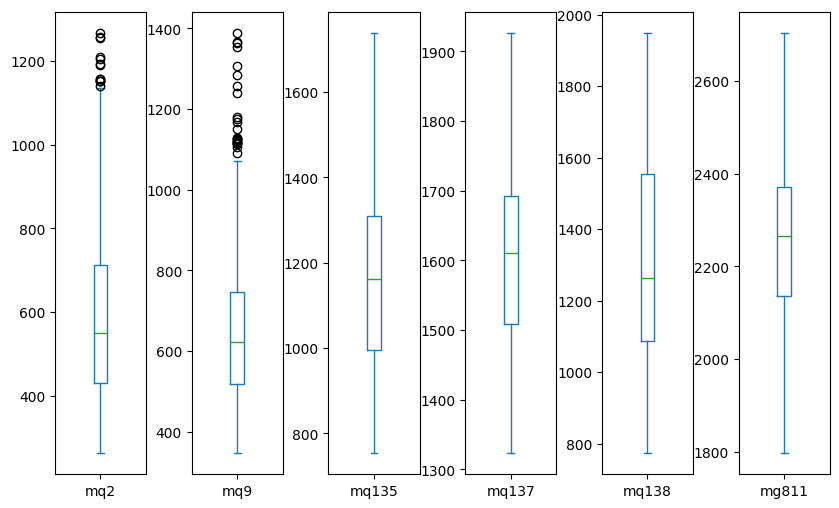

In [48]:
# Boxplot visualization of all numeric feature variables
df.loc[:, feature_columns].plot(kind='box', subplots=True, sharey=False, figsize=(10, 6))
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [49]:
# Get the percentage of outlier data on the variables 'mq2' and 'mq9'
outlier_columns = ['mq2', 'mq9']

# Get outlier limits
def outlier_bound(datacolumn):
  sorted(datacolumn)  # Memastikan data sudah urut
  Q1, Q3 = np.percentile(datacolumn , [25,75])
  IQR = Q3 - Q1
  lower_bound = Q1 - (1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  return lower_bound, upper_bound

# Check the percentage of outlier values ​​in the following two variables
for column in outlier_columns:
  lower_bound, upper_bound = outlier_bound(df[column])
  display(((df[[column]] < lower_bound) | (df[[column]] > upper_bound)).sum().apply(lambda x: '{:.2f}%'.format(x/len(df)*100)))

mq2    0.70%
dtype: object

mq9    1.30%
dtype: object

<Axes: >

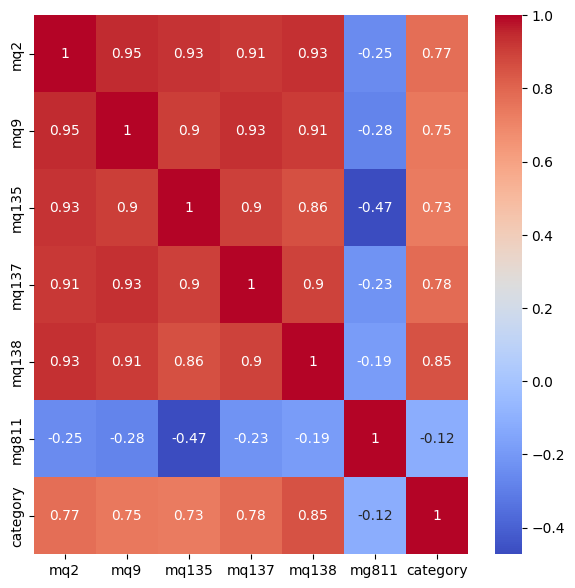

In [50]:
# Calculates the correlation matrix for all numeric feature variables to the target
correlation_matrix = df[df.columns].corr()

# Heatmap correlation matrix visualization
plt.figure(figsize = (7, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

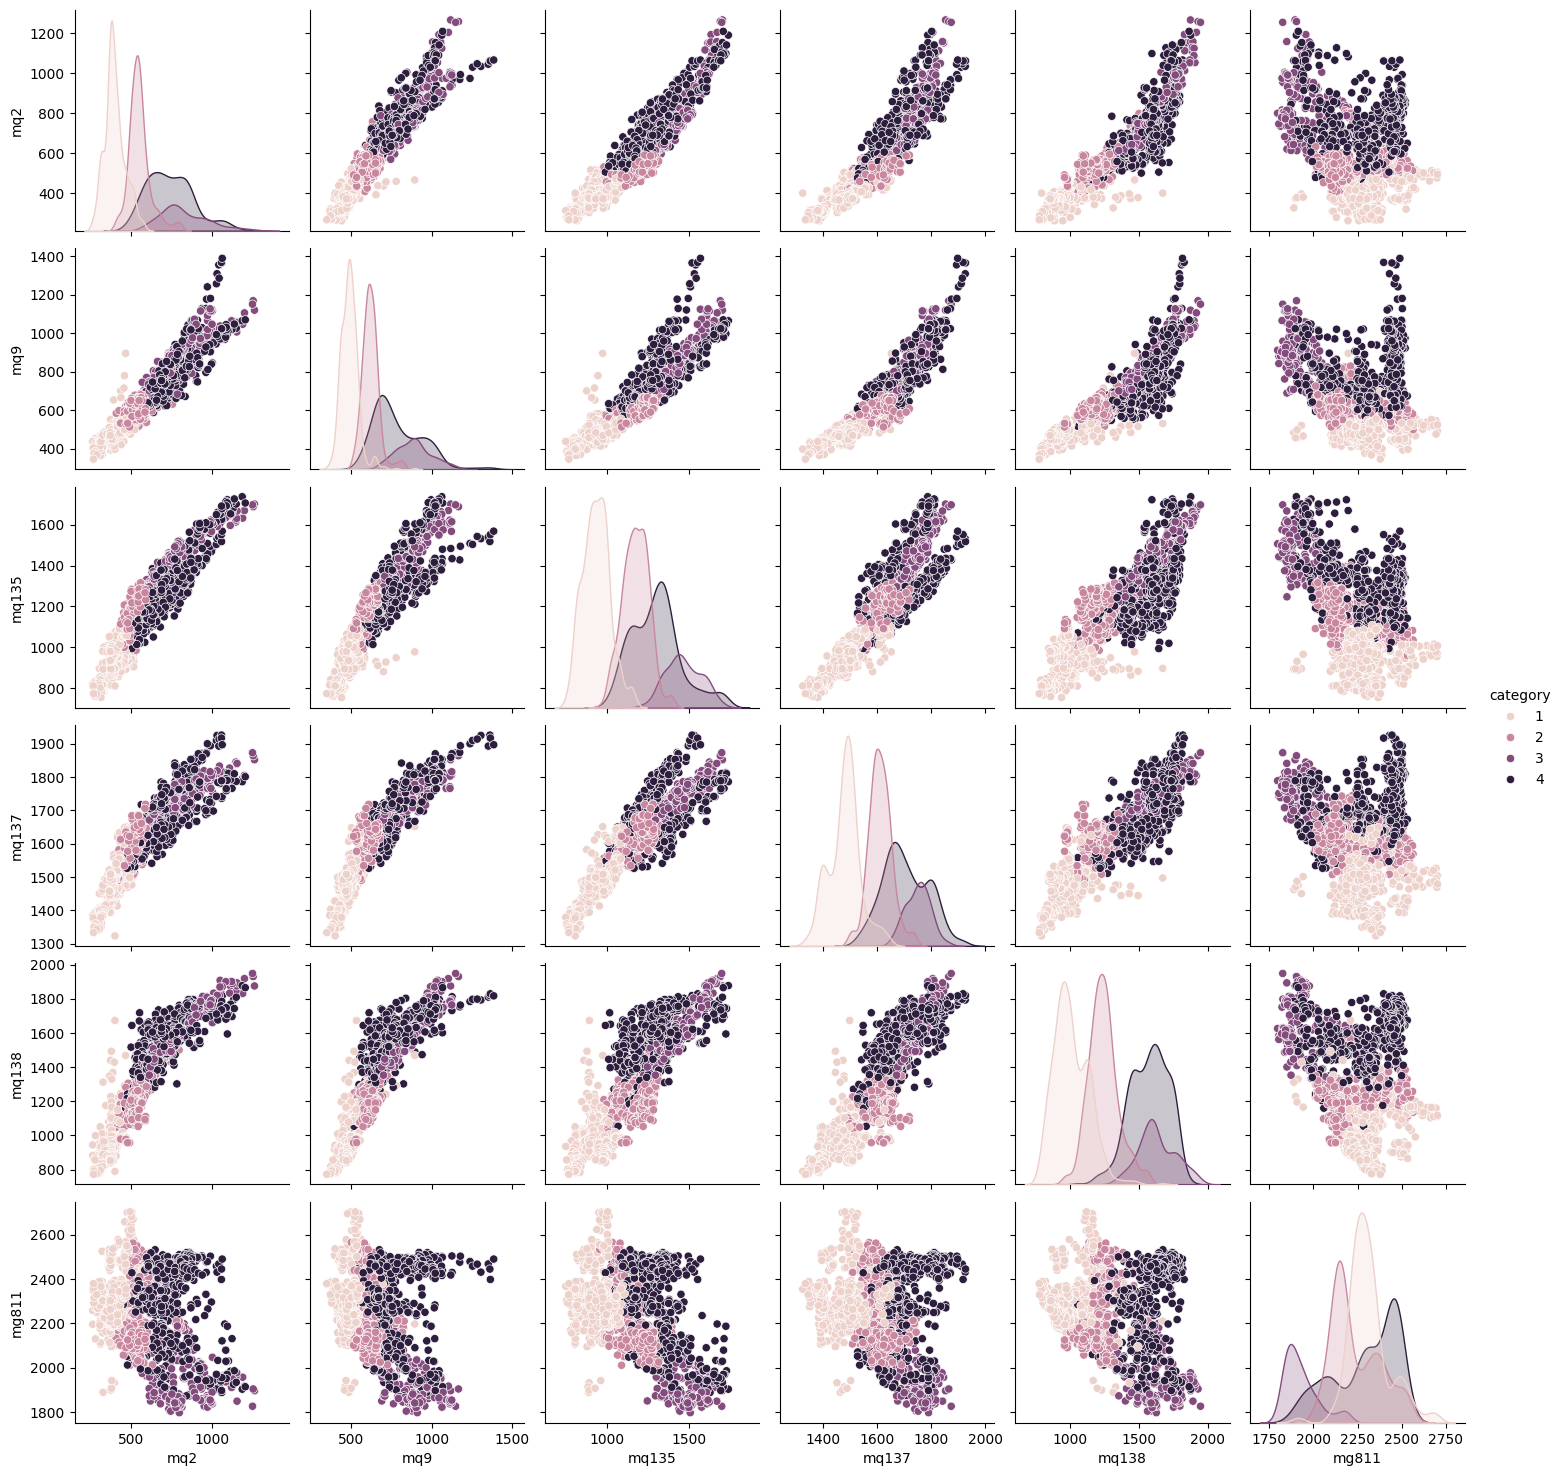

In [51]:
# View the scatter plot of each pair of variables
sns.pairplot(data=df, hue=target_column)

<Axes: xlabel='mq2', ylabel='mq135'>

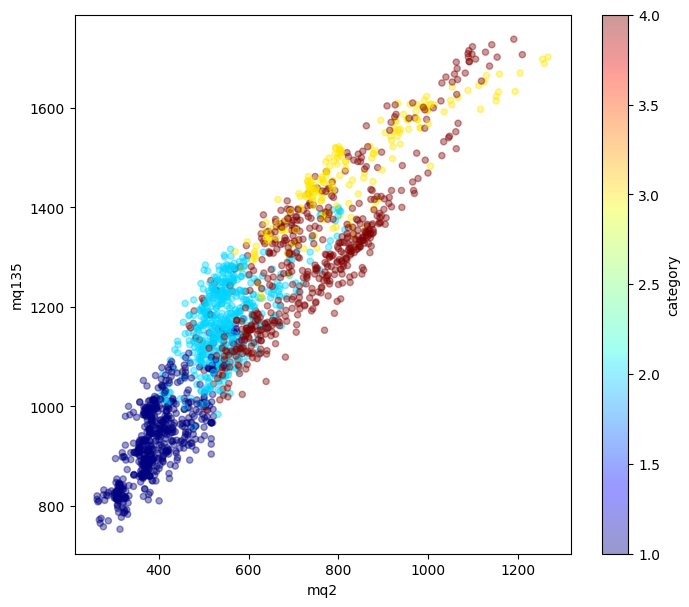

In [52]:
# Create a scatter plot on the variables to be used (mq2 and mq135), by playing with visual elements
df[['mq2', 'mq135', 'category']].plot(
    kind='scatter',
    x='mq2',
    y='mq135',
    alpha=0.4,
    figsize=(8, 7),
    c='category',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)

Based on the EDA that has been carried out, several information has been obtained.
- Feature data is quite well distributed
- Each feature variable appears with a different range.
- The `category` target data is a bit unbalanced
- There are outliers in the `mq2` and `mq9` features, amounting to 0.70% and 1.30%
- All features have a correlation to the target variable with the smallest being 73% (`mq135`) and the largest being 85% (`mq138`).
- The scatter plot of the features to be used (`mq2` and `mq135`) has a fairly clear target distribution, but for `category` 3 and 4 the scatter plot is more random.

Data preparation steps.
- Scaling the feature variable to equalize the range
- Because the number of outliers is very small (x < 5%), the outlier rows can be deleted
- Merge `category` 3 and 4 into one with label 3 (TIDAK SEHAT / unhealthy)
- It is necessary to balance the data based on the target variable `category`

# **Data Cleaning & Preparation**

## **Delete Unused Variables**

In [53]:
# keep following variables
feature_columns = ['mq2', 'mq135']
target_column = 'category'

In [54]:
# Remove unnecessary variables
df_cleaned = df.drop(['mq9', 'mq137', 'mq138', 'mg811'], axis=1)

# Remaining variables
print(f"Remaining variables: {list(df_cleaned.columns)}")

Remaining variables: ['mq2', 'mq135', 'category']


## **Fix target variable**

In [55]:
# Changing category 4 to 3
df_cleaned.loc[df_cleaned['category'] == 4, 'category'] = 3
df_cleaned['category'].value_counts()

category
3    734
1    595
2    515
Name: count, dtype: int64

In [56]:
# Change category data format
df_cleaned = df_cleaned.replace({
    'category': {
        1: 0,
        2: 1,
        3: 2
    }
})

df_cleaned['category'].value_counts()

category
2    734
0    595
1    515
Name: count, dtype: int64

<Axes: xlabel='mq2', ylabel='mq135'>

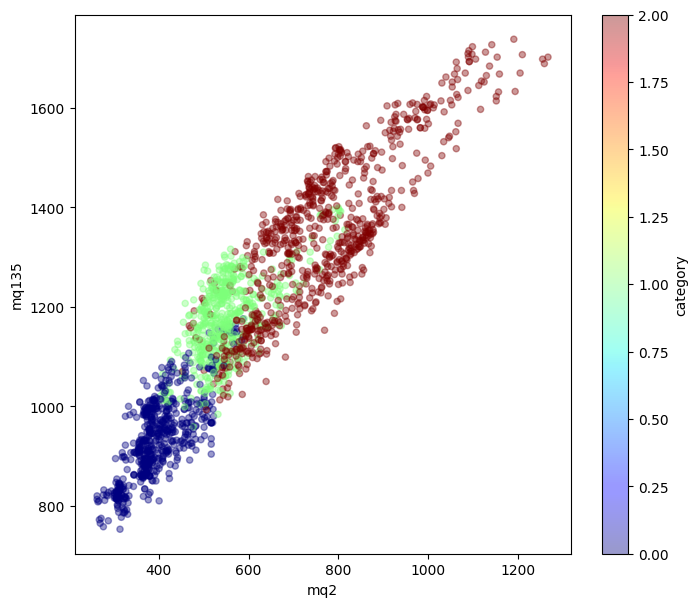

In [57]:
# Create a scatter plot on the variables to be used (mq2 and mq135), by playing with visual elements
df_cleaned.plot(
    kind='scatter',
    x='mq2',
    y='mq135',
    alpha=0.4,
    figsize=(8, 7),
    c='category',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)

## **Delete Outliers**

In [58]:
outlier_columns = ['mq2'] # mq9 has been removed
print(f"Amount of data before removing outliers: {len(df_cleaned)}")

# Remove outliers
for column in outlier_columns:
  lower_bound, upper_bound = outlier_bound(df_cleaned[column])
  df_cleaned = df_cleaned.drop(df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)].index)\
    .reset_index(inplace=False, drop=True)

print(f"Amount of data after removing outliers: {len(df_cleaned)}")

Amount of data before removing outliers: 1844
Amount of data after removing outliers: 1831


## **Delete Duplicate Values**

In [59]:
# Check and delete duplicate data in the feature
print(f"Amount of data before deleting duplicate data: {len(df_cleaned)}")
print(f"Number of duplicate data: {df_cleaned.duplicated().sum()}")
df_cleaned = df_cleaned.drop_duplicates().reset_index(inplace=False, drop=True)

print(f"Amount of data after deleting duplicate data: {len(df_cleaned)}")

Amount of data before deleting duplicate data: 1831
Number of duplicate data: 31
Amount of data after deleting duplicate data: 1800


In [61]:
# Save the clean dataset
clean_dataset = 'datasets/clean_dataset.csv'
df_cleaned.to_csv(clean_dataset, index=False)

## **Data Balancing**

Because the target variable has a very unbalanced distribution, balancing is necessary.

In [62]:
# Load clean dataset to dataframe
clean_dataset = 'datasets/clean_dataset.csv'
df_cleaned = pd.read_csv(clean_dataset)
df_cleaned.sample(5)

,mq2,mq135,category
1454,380,921,0
699,848,1367,2
1691,872,1436,2
1027,522,1132,1
957,387,974,0


In [63]:
# Separating features and target
X_new = df_cleaned.drop(target_column, axis=1)  # feature
y_new = df_cleaned[target_column]               # target

X_new.reset_index(drop=True, inplace=True)
y_new.reset_index(drop=True, inplace=True)

In [64]:
# Balances the value of the target variable
balancer = RandomOverSampler(random_state=42)
X_balanced, y_balanced = balancer.fit_resample(X_new, y_new)
y_balanced.value_counts()

category
2    713
0    713
1    713
Name: count, dtype: int64

<Axes: xlabel='mq2', ylabel='mq135'>

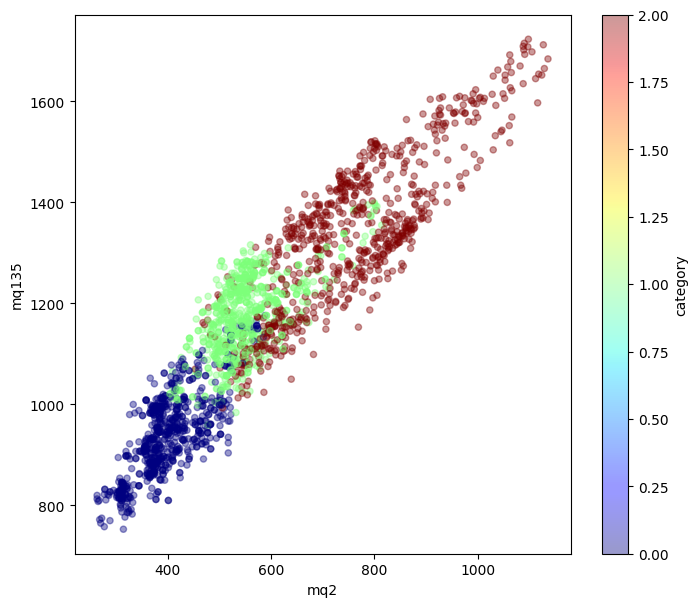

In [65]:
# Create a scatter plot on the balancing result variables, by playing with visual elements.
df_balanced = X_balanced.copy()
df_balanced['category'] = y_balanced
df_balanced.plot(
    kind='scatter',
    x='mq2',
    y='mq135',
    alpha=0.4,
    figsize=(8, 7),
    c='category',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)

## **Data Splitting**

Divide the dataset into 80% training data and 20% testing data. Data division is carried out based on the ratio of the target variable.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
new_feature = X_test.tail(28)  # Take 28 feature tests to simulate new data (see New Data Simulation section)
new_target = y_test.tail(28)  # Take 28 feature tests to simulate new data (see New Data Simulation section)
X_test = X_test[:-28]
y_test = y_test[:-28]
print(f"Data training: {len(X_train)}")
print(f"Data testing: {len(X_test)}")

Data training: 1711
Data testing: 400


## **Data Scaling**

Scaling the data so that it has a range that is not much different.

In [67]:
# Data before scaling
X_train.describe()

,mq2,mq135
count,1711.000000,1711.000000
mean,569.015780,1152.287551
std,175.016194,196.934484
min,263.000000,753.000000
25%,425.000000,992.000000
50%,542.000000,1156.000000
75%,674.500000,1281.000000
max,1129.000000,1723.000000


In [68]:
# Perform scaling on training and test features
minmax_scaler = MinMaxScaler()

X_train_scaled = X_train.copy()
X_train_scaled[feature_columns] = minmax_scaler.fit_transform(X_train[feature_columns])

X_test_scaled = X_test.copy()
X_test_scaled[feature_columns] = minmax_scaler.transform(X_test[feature_columns])

In [69]:
# Data after scaling
X_train_scaled.describe()

,mq2,mq135
count,1711.000000,1711.000000
mean,0.353367,0.411637
std,0.202097,0.203025
min,0.000000,0.000000
25%,0.187067,0.246392
50%,0.322171,0.415464
75%,0.475173,0.544330
max,1.000000,1.000000


# **Machine Learning**

## **Explore Different Models**

Trying to use various machine learning models for classification (default parameters) to predict the `category` variable.

In [70]:
# Instantiation of various classification models
sgdc = SGDClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

In [71]:
# Perform cross validation on all classification models
models = [sgdc, lr, svc, knn, dtc, rf]
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

for model in models:
    print(f"{'Model':<21}: {type(model).__name__}")
    scores = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scoring)
    for score in scores.keys():
        print(f"{score:<21}: {scores[score]}")
    print()

Model                : SGDClassifier
fit_time             : [0.0210979  0.0159905  0.01600575 0.01600337 0.012007  ]
score_time           : [0.02001882 0.0120039  0.01200271 0.01200223 0.01200032]
test_precision_macro : [0.83464399 0.84608266 0.81538061 0.82676346 0.83220675]
test_recall_macro    : [0.83358759 0.84795322 0.79824561 0.82748538 0.82748538]
test_f1_macro        : [0.83092146 0.84622384 0.788852   0.82271682 0.82365229]
test_accuracy        : [0.83381924 0.84795322 0.79824561 0.82748538 0.82748538]

Model                : LogisticRegression
fit_time             : [0.01200318 0.01599264 0.01600552 0.02000618 0.01757312]
score_time           : [0.01201439 0.01600385 0.01600337 0.01200414 0.00801396]
test_precision_macro : [0.86231933 0.8900745  0.86798459 0.8699095  0.8677112 ]
test_recall_macro    : [0.85397915 0.88304094 0.86549708 0.86842105 0.86549708]
test_f1_macro        : [0.85452346 0.88391351 0.86580873 0.86829153 0.86636279]
test_accuracy        : [0.85422741 0.883

- The best precision, recall, f1-score, and accuracy results are obtained when using Random Forest
- However, the Decision Tree and KNN models also provide quite similar results
- Based on the scatter plots of `mq2` and `mq135` that have been made, it can be seen that data with the same `category` is quite well collected in one place. So there is a possibility that KNN will be suitable for use in this case and produce more general results than overfitting to the training data.
- So in the future the KNN model will be used

## **Training the Model**

The KNN model has many parameters that can be adjusted. To get the best results, it is necessary to conduct trials to determine the best combination of parameters. Therefore, a fine tuning process will be carried out on the KNN hyperparameters, where the best combination of parameters will be determined, from various combinations of parameters.

In [32]:
# KNN to be fine tuned
estimator_KNN = KNeighborsClassifier()

# List of parameters to be tested
parameters_KNN = {
    'n_neighbors': tuple(range(1, 31)),
    'weights': ('uniform', 'distance'),
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'leaf_size': tuple(range(20, 41)),
    'p': (1, 2),
    'metric': ('minkowski', 'chebyshev')
}
                   
# Use GridSearch to perform fine tuning
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring=scoring,
    n_jobs=-1,
    refit='accuracy',
    cv=5
)

grid_search_KNN.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': (20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                                       40),
                         'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30),
                         'p': (1, 2), 'weights': ('uniform', 'distance')},
             refit='accuracy',
             scoring=['precision_macro', 'recall_macro', 'f1_macro',
                      'accuracy'])

In [72]:
# Show parameter setting that gave the best results on the hold out data.
print(grid_search_KNN.best_params_ )

# Show mean cross-validated score of the best_estimator
print('Best Score - KNN:', grid_search_KNN.best_score_ )

{'algorithm': 'auto', 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30, 'p': 2, 'weights': 'distance'}
Best Score - KNN: 0.9024005592211821


In [73]:
# Creating a KNN instance using the best parameter combination
knn = KNeighborsClassifier(
    n_neighbors=30,
    algorithm='auto',
    leaf_size=20,
    metric='minkowski',
    p=2,
    weights='distance'
)

scores = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring=scoring)
for score in scores.keys():
    print(f"{score:<21}: {scores[score]}")

fit_time             : [0.00401211 0.00401592 0.00801301 0.0039978  0.00398302]
score_time           : [0.01757526 0.01599097 0.008008   0.01200724 0.01600695]
test_precision_macro : [0.89874533 0.9021164  0.91384401 0.92098188 0.89084907]
test_recall_macro    : [0.89494025 0.89766082 0.9122807  0.92105263 0.88596491]
test_f1_macro        : [0.89571005 0.89872372 0.91271164 0.92086272 0.88746924]
test_accuracy        : [0.89504373 0.89766082 0.9122807  0.92105263 0.88596491]


In [74]:
# Train a new Random Forest model on the entire training data
knn.fit(X_train_scaled, y_train)
y_train_pred = knn.predict(X_train_scaled)

print(confusion_matrix(y_train, y_train_pred), "\n")
print(classification_report(y_train, y_train_pred))

[[571   0   0]
 [  0 570   0]
 [  0   0 570]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       571
           1       1.00      1.00      1.00       570
           2       1.00      1.00      1.00       570

    accuracy                           1.00      1711
   macro avg       1.00      1.00      1.00      1711
weighted avg       1.00      1.00      1.00      1711



<Axes: title={'center': 'Training - Predicted Category'}, xlabel='mq2', ylabel='mq135'>

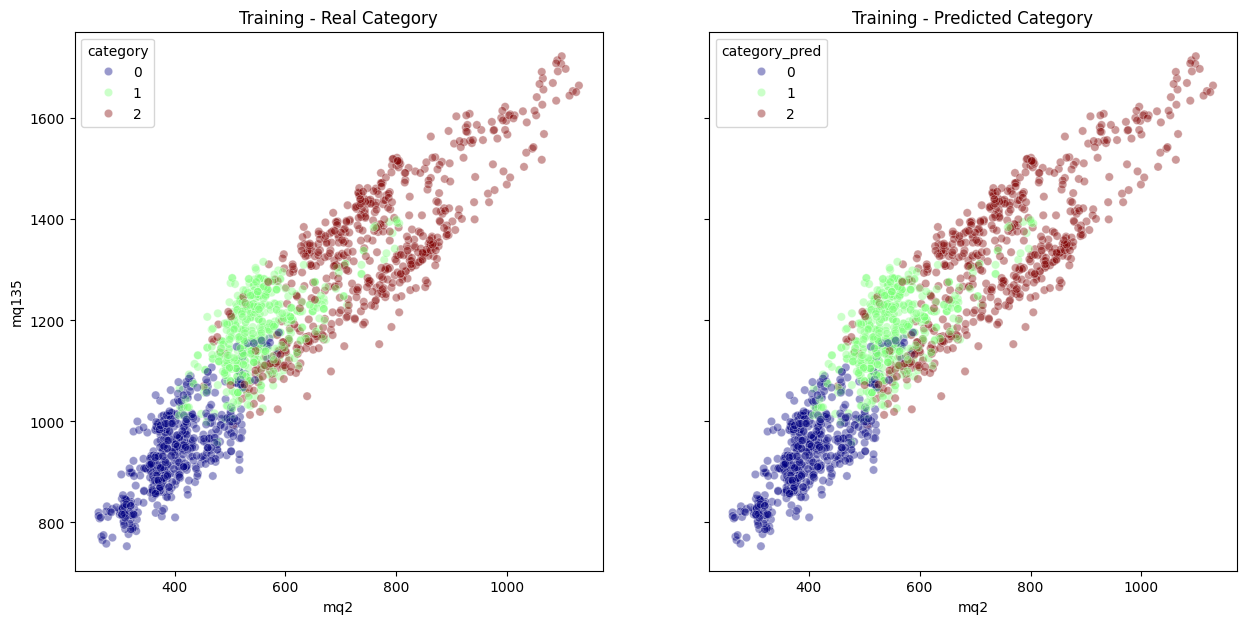

In [75]:
# Comparing training results into scatter plots
training_results = X_train.copy()
training_results['category'] = y_train
training_results['category_pred'] = y_train_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

axes[0].set_title('Training - Real Category')
sns.scatterplot(
    data=training_results,
    x='mq2',
    y='mq135',
    alpha=0.4,
    hue='category',
    palette=plt.get_cmap('jet'),
    ax=axes[0]
)

axes[1].set_title('Training - Predicted Category')
sns.scatterplot(
    data=training_results,
    x='mq2',
    y='mq135',
    alpha=0.4,
    hue='category_pred',
    palette=plt.get_cmap('jet'),
    ax=axes[1]
)

## **Evaluate the Model**

In [76]:
# Make predictions on testing data and evaluate the results
y_test_pred = knn.predict(X_test_scaled)
print(confusion_matrix(y_test, y_test_pred), "\n")
print(classification_report(y_test, y_test_pred))

[[127   2   0]
 [  3 122  12]
 [  0  25 109]] 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       129
           1       0.82      0.89      0.85       137
           2       0.90      0.81      0.85       134

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.89       400



The model still seems to be overfitting. This is likely due to several things.
- The amount of training data is not enough
- The target variables are not balanced
- The sensors are not accurate enough in reading indoor gases
- The types and number of sensors used are not enough to conclude the air quality category

But if we compare it in the form of a scatter plot, the results do not look bad, **KNN is quite successful in generalizing data patterns**.

<Axes: title={'center': 'Testing - Predicted Category'}, xlabel='mq2', ylabel='mq135'>

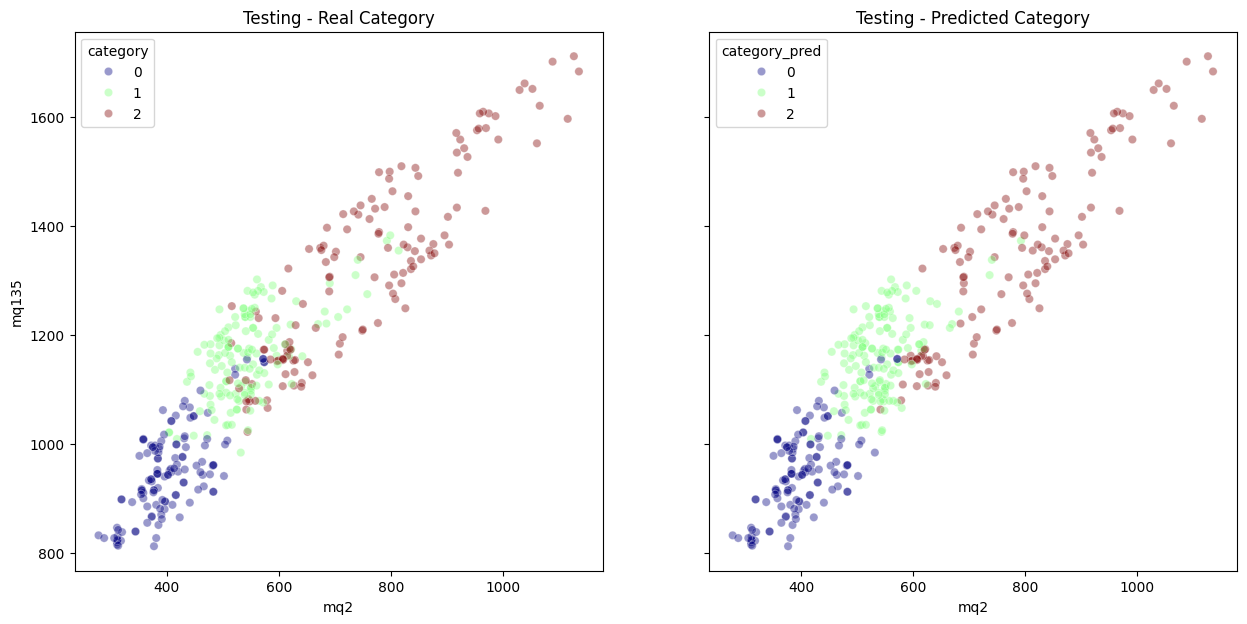

In [77]:
# Comparing test results into scatter plots
test_results = X_test.copy()
test_results['category'] = y_test
test_results['category_pred'] = y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

axes[0].set_title('Testing - Real Category')
sns.scatterplot(
    data=test_results,
    x='mq2',
    y='mq135',
    alpha=0.4,
    hue='category',
    palette=plt.get_cmap('jet'),
    ax=axes[0]
)

axes[1].set_title('Testing - Predicted Category')
sns.scatterplot(
    data=test_results,
    x='mq2',
    y='mq135',
    alpha=0.4,
    hue='category_pred',
    palette=plt.get_cmap('jet'),
    ax=axes[1]
)

## **New Data Simulation**

In [78]:
# View new data information
print(f"Amount of new data: {len(new_feature)}")
print(f"New target: {new_target.value_counts()}")

Amount of new data: 28
New target: category
0    13
2     9
1     6
Name: count, dtype: int64


In [79]:
# Scaling new data using the declared minmax_scaler
new_feature_scaled = new_feature.copy()
new_feature_scaled[feature_columns] = minmax_scaler.transform(new_feature[feature_columns])

In [80]:
# Make predictions on new data
new_target_pred = knn.predict(new_feature_scaled)
print(confusion_matrix(new_target, new_target_pred), "\n")
print(classification_report(new_target, new_target_pred))

[[13  0  0]
 [ 0  6  0]
 [ 0  2  7]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.75      1.00      0.86         6
           2       1.00      0.78      0.88         9

    accuracy                           0.93        28
   macro avg       0.92      0.93      0.91        28
weighted avg       0.95      0.93      0.93        28



<Axes: title={'center': 'New Data - Predicted Category'}, xlabel='mq2', ylabel='mq135'>

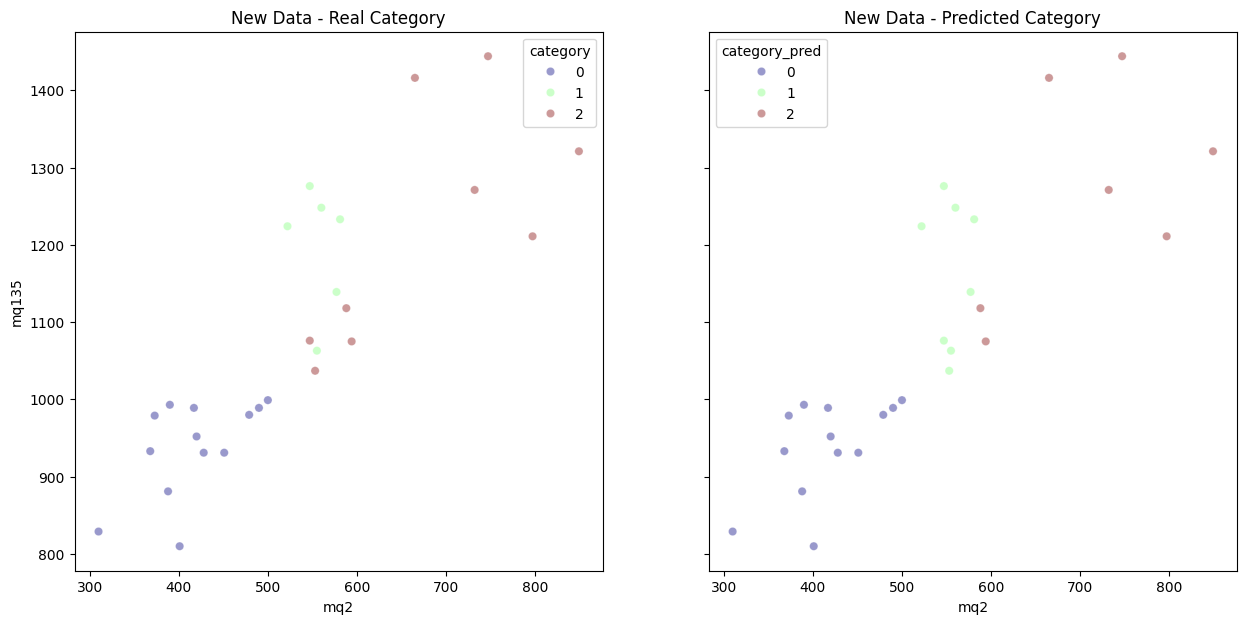

In [81]:
# Comparing test results into scatter plots
test_new_data = new_feature.copy()
test_new_data['category'] = new_target
test_new_data['category_pred'] = new_target_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

axes[0].set_title('New Data - Real Category')
sns.scatterplot(
    data=test_new_data,
    x='mq2',
    y='mq135',
    alpha=0.4,
    hue='category',
    palette=plt.get_cmap('jet'),
    ax=axes[0]
)

axes[1].set_title('New Data - Predicted Category')
sns.scatterplot(
    data=test_new_data,
    x='mq2',
    y='mq135',
    alpha=0.4,
    hue='category_pred',
    palette=plt.get_cmap('jet'),
    ax=axes[1]
)

## **Export the Model**

In [82]:
# KNN will be saved using the following sklearn version
print(sklearn.__version__)

1.3.2


In [83]:
# Create KNN pipeline
pipeline = Pipeline([
  ('minmax_scaler', MinMaxScaler()),
  ('knn', KNeighborsClassifier(
      n_neighbors=30,
      algorithm='auto',
      leaf_size=20,
      metric='minkowski',
      p=2,
      weights='distance'
  ))
])

# Fit data on model pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('minmax_scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(leaf_size=20, n_neighbors=30,
                                      weights='distance'))])

In [84]:
# Save the KNN pipeline
model_name_or_path = 'models/knn_pipeline.pkl'

with open(model_name_or_path, 'wb') as f:
  pickle.dump(pipeline, f)

In [85]:
# test load KNN pipeline
model_name_or_path = 'models/knn_pipeline.pkl'

with open(model_name_or_path, 'rb') as f:
  loaded_model = pickle.load(f)

In [86]:
y_test_pred = loaded_model.predict(X_test)
print(confusion_matrix(y_test, y_test_pred), "\n")
print(classification_report(y_test, y_test_pred))

[[127   2   0]
 [  3 122  12]
 [  0  25 109]] 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       129
           1       0.82      0.89      0.85       137
           2       0.90      0.81      0.85       134

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.89       400



In [87]:
# Test the loaded model on a new data example
data = [{
  'mq2': 500,
  'mq135': 1000
}]
feature = pd.DataFrame(data)

AIR_QUALITY_ID = ['BAIK', 'SEDANG', 'TIDAK SEHAT']
AIR_QUALITY_ENG = ['GOOD', 'MODERATE', 'UNHEALTHY']

# Predict on new data
y_test_pred = loaded_model.predict(feature)
print(AIR_QUALITY_ID[y_test_pred[0]])
print(AIR_QUALITY_ENG[y_test_pred[0]])

BAIK
GOOD
